# XRD Pattern Matching

This notebook demonstrates how to match experimental XRD patterns to the database.

## Steps:
1. Import modules
2. Initialize the retriever
3. Read experimental XRD data
4. Match against database
5. Analyze results

## 1. Import Modules

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys

# Reload modules to get latest changes
if 'retrieve.retriever' in sys.modules:
    import retrieve.retriever
    import retrieve.xrd_reader
    import retrieve.peak_detector
    import retrieve.matcher
    importlib.reload(retrieve.matcher)
    importlib.reload(retrieve.peak_detector)
    importlib.reload(retrieve.xrd_reader)
    importlib.reload(retrieve.retriever)

from retrieve.retriever import XRDRetriever
from retrieve.xrd_reader import XRDReader
from retrieve.peak_detector import PeakDetector

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Modules imported successfully (with reload)")

✓ Modules imported successfully (with reload)


## 2. Configuration

In [32]:
# Database path
database_path = 'xrd_database.pkl'

# Matching parameters
position_tolerance = 0.2  # Maximum 2θ difference (degrees) - UPDATED for better accuracy
min_peak_height = 5.0  # Minimum peak height (% of max)
min_peak_prominence = 3.0  # Minimum peak prominence (% of max)
n_peaks = 5  # Number of peaks to use for matching (top 5 strongest)
top_n = 10  # Number of top matches to return

# Scoring method - NEW FEATURE!
# Options: 'weighted', 'fom', 'combined'
# - 'weighted': Traditional 70% position + 30% intensity similarity
# - 'fom': Figure of Merit (fraction of matched peak intensity)
# - 'combined': Returns both weighted and FOM scores
scoring_method = 'combined'  # Recommended: get both metrics

print("Configuration:")
print(f"  Database: {database_path}")
print(f"  Position tolerance: ±{position_tolerance}°")
print(f"  Min peak height: {min_peak_height}%")
print(f"  Number of peaks: {n_peaks} (top strongest peaks)")
print(f"  Scoring method: {scoring_method}")
print(f"  Top matches: {top_n}")

Configuration:
  Database: xrd_database.pkl
  Position tolerance: ±0.2°
  Min peak height: 5.0%
  Number of peaks: 5 (top strongest peaks)
  Scoring method: combined
  Top matches: 10


## 3. Initialize Retriever

In [33]:
# Initialize retriever with new scoring method parameter
retriever = XRDRetriever(
    database_path=database_path,
    position_tolerance=position_tolerance,
    min_peak_height=min_peak_height,
    min_peak_prominence=min_peak_prominence,
    n_peaks=n_peaks,
    scoring_method=scoring_method  # NEW: Use combined scoring
)

# Get database statistics
stats = retriever.get_database_statistics()
print(f"\nDatabase Statistics:")
print(f"  Total entries: {stats['total_entries']}")
print(f"  Unique elements: {stats['n_unique_elements']}")
print(f"  Unique formulas: {stats['unique_formulas']}")
print(f"  Wavelength: {stats['wavelength']}")
print(f"  2θ range: {stats['two_theta_range']}")

INFO:retrieve.retriever:Loading XRD database from xrd_database.pkl
INFO:retrieve.retriever:Loaded database with 100315 entries
INFO:retrieve.xrd_reader:XRDReader initialized
INFO:retrieve.peak_detector:PeakDetector initialized with height=5.0%, prominence=3.0%, distance=0.1°
INFO:retrieve.matcher:XRDMatcher initialized with tolerance=0.2°, weights=(pos:0.70, int:0.30), scoring_method='combined'
INFO:retrieve.retriever:XRDRetriever initialized successfully



Database Statistics:
  Total entries: 100315
  Unique elements: 84
  Unique formulas: 87947
  Wavelength: CuKa
  2θ range: (10.0, 90.0)


## Load Your Own XRD Data

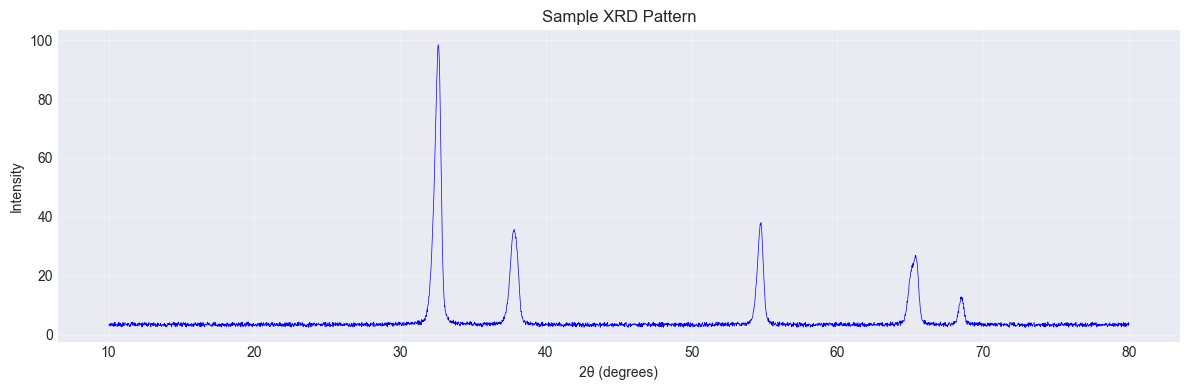

In [42]:
import pandas as pd

xrd_file = './exp_data/BTc.csv'
xrd_data = pd.read_csv(xrd_file)
two_theta = xrd_data.iloc[:,0]
intensity = xrd_data.iloc[:,1]


# Plot
plt.figure(figsize=(12, 4))
plt.plot(two_theta, intensity, 'b-', linewidth=0.5)
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity')
plt.title('Sample XRD Pattern')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Detect Peaks

In [43]:
# Initialize peak detector
detector = PeakDetector(
    min_peak_height=min_peak_height,
    min_peak_prominence=min_peak_prominence
)

# Detect peaks
peaks = detector.get_top_peaks(
    two_theta=two_theta,
    intensity=intensity,
    n_peaks=n_peaks,
    preprocess=True
)

print(f"Detected {len(peaks)} peaks:")
print("=" * 60)
for i, peak in enumerate(peaks, 1):
    print(f"{i}. 2θ = {peak['two_theta']:6.2f}°, Intensity = {peak['intensity']:6.1f}")

# Extract positions and intensities
exp_positions, exp_intensities = detector.extract_peak_positions_and_intensities(peaks)

INFO:retrieve.peak_detector:PeakDetector initialized with height=5.0%, prominence=3.0%, distance=0.1°
INFO:retrieve.peak_detector:Detected 5 peaks
INFO:retrieve.peak_detector:Normalized peak intensities to max=100
INFO:retrieve.peak_detector:Returning top 5 peaks out of 5 detected


Detected 5 peaks:
1. 2θ =  32.61°, Intensity =  100.0
2. 2θ =  54.75°, Intensity =   36.6
3. 2θ =  37.83°, Intensity =   34.5
4. 2θ =  65.36°, Intensity =   25.0
5. 2θ =  68.52°, Intensity =   10.5


## 5. Visualize Detected Peaks

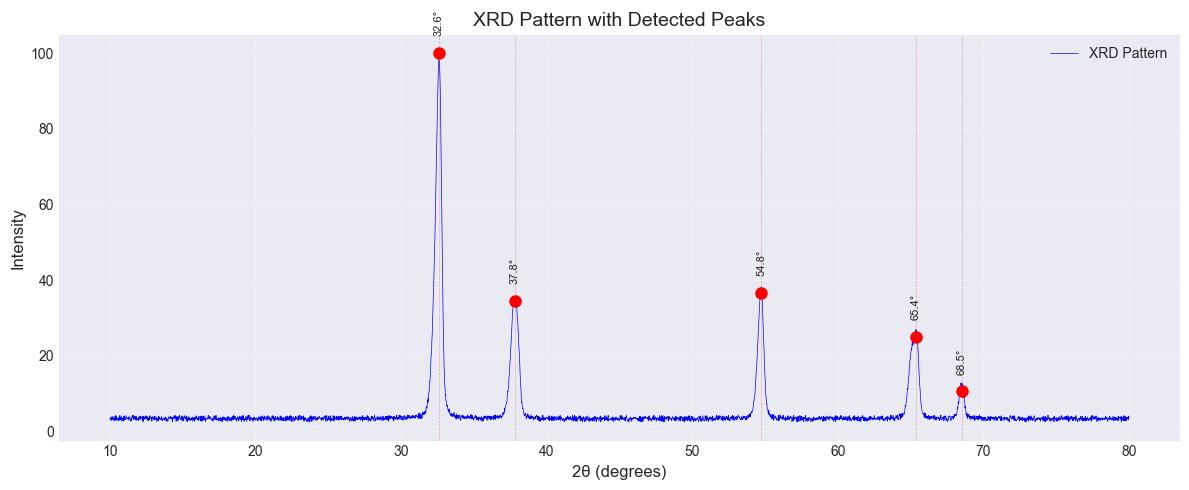

In [44]:
# Plot XRD pattern with detected peaks
plt.figure(figsize=(12, 5))
plt.plot(two_theta, intensity, 'b-', linewidth=0.5, label='XRD Pattern')

# Mark detected peaks
for peak in peaks:
    plt.plot(peak['two_theta'], peak['intensity'], 'ro', markersize=8)
    plt.axvline(peak['two_theta'], color='r', linestyle='--', alpha=0.3, linewidth=0.5)
    plt.text(peak['two_theta'], peak['intensity'] + 5, 
             f"{peak['two_theta']:.1f}°", 
             ha='center', fontsize=8, rotation=90)

plt.xlabel('2θ (degrees)', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.title('XRD Pattern with Detected Peaks', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Match Against Database

In [45]:
# Specify required elements
# Modify this list based on your sample composition
elements = ['B','Tc']  

print(f"Searching for structures containing: {', '.join(elements)}")
print("=" * 80)

# Perform matching
results = retriever.retrieve_from_peaks(
    peak_positions=exp_positions.tolist(),
    peak_intensities=exp_intensities.tolist(),
    elements=elements,
    top_n=top_n
)

print(f"\nFound {len(results)} matches")

INFO:retrieve.retriever:Matching 5 peaks
INFO:retrieve.retriever:Required elements: ['B', 'Tc']


Searching for structures containing: B, Tc


INFO:retrieve.matcher:Found 9 entries containing elements ['B', 'Tc']
INFO:retrieve.matcher:Matching against 9 candidate entries...
INFO:retrieve.matcher:Found 3 matches, returning top 3
INFO:retrieve.matcher:Best match: BTc (score: 63.72)



Found 3 matches


## 7. Display Results

In [46]:
# Print results with new FOM scoring
retriever.print_results(results, max_results=top_n)


Top 3 Matches:

1. Score: 63.72 | FOM: 100.00 | Matched: 5 peaks
   MPID: mp-1002184.cif
   Formula: BTc
   Elements: B, Tc
   Space Group: 216

2. Score: 0.00 | FOM: 35.00 | Matched: 1 peaks
   MPID: mp-1002183.cif
   Formula: BTc
   Elements: B, Tc
   Space Group: 221

3. Score: 0.00 | FOM: 56.37 | Matched: 3 peaks
   MPID: mp-1019317.cif
   Formula: B4Tc2
   Elements: B, Tc
   Space Group: 63



### Understanding the Scores

When using `scoring_method='combined'`, you get two complementary metrics:

1. **Weighted Score** (0-100): Traditional similarity score
   - 70% based on peak position matching
   - 30% based on intensity similarity
   - Higher is better

2. **FOM (Figure of Merit)** (0-100): Quantitative match quality
   - Percentage of database peak intensity that is matched
   - FOM = (Σ matched intensities / Σ total intensities) × 100
   - Commonly used in crystallography for phase identification
   - Higher is better

3. **Matched Peaks**: Number of peaks successfully matched within tolerance

**Interpretation:**
- High weighted score + High FOM = Excellent match
- High weighted score + Low FOM = Good peak positions but missing some peaks
- Low weighted score + High FOM = Peaks match but with position/intensity deviations


## 8. Detailed Analysis of Top Match

In [47]:
if len(results) > 0:
    # Get top match details
    top_match = results[0]
    entry = retriever.get_entry_details(top_match['entry_id'])
    
    print("Top Match Details:")
    print("=" * 80)
    print(f"Entry ID: {entry['entry_id']}")
    print(f"MPID: {entry['mpid']}")
    print(f"Formula: {entry['formula']}")
    print(f"Elements: {', '.join(entry['elements'])}")
    print(f"Space Group: {entry['spacegroup_number']} ({entry['spacegroup_symbol']})")
    print(f"Number of atoms: {entry['n_atoms']}")
    print(f"Match Score: {top_match['score']:.2f}")
    print()
    print("Database Peaks:")
    for i, (pos, intensity) in enumerate(zip(entry['peaks']['positions'], 
                                             entry['peaks']['intensities']), 1):
        print(f"  {i}. 2θ = {pos:6.2f}°, Intensity = {intensity:6.1f}")
else:
    print("No matches found")

Top Match Details:
Entry ID: 37
MPID: mp-1002184.cif
Formula: BTc
Elements: B, Tc
Space Group: 216 (F -4 3 m)
Number of atoms: 2
Match Score: 63.72

Database Peaks:
  1. 2θ =  32.76°, Intensity =  100.0
  2. 2θ =  38.01°, Intensity =   42.0
  3. 2θ =  65.38°, Intensity =   38.7
  4. 2θ =  54.85°, Intensity =   37.9
  5. 2θ =  68.68°, Intensity =    9.6


## 9. Compare Experimental vs Database Peaks

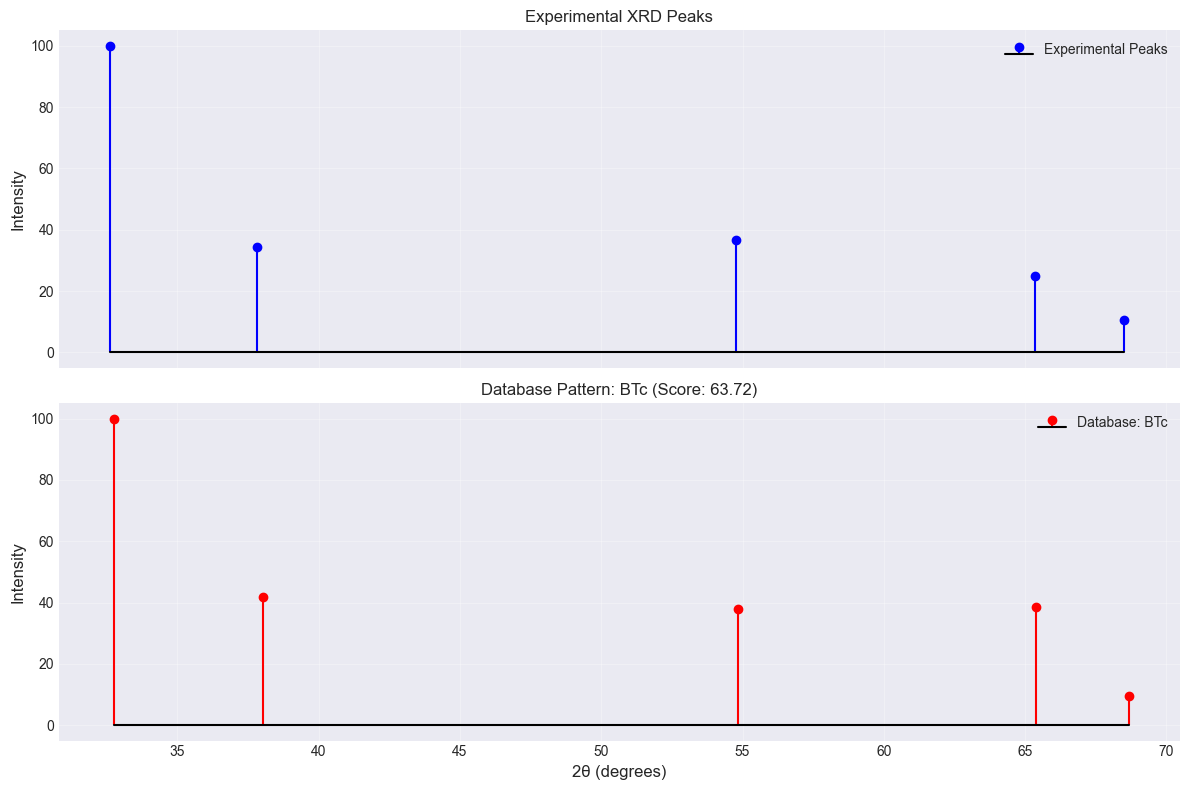


Peak Comparison:
Experimental Peaks:
  1. 2θ =  32.61°, Intensity =  100.0
  2. 2θ =  54.75°, Intensity =   36.6
  3. 2θ =  37.83°, Intensity =   34.5
  4. 2θ =  65.36°, Intensity =   25.0
  5. 2θ =  68.52°, Intensity =   10.5

Database Peaks:
  1. 2θ =  32.76°, Intensity =  100.0
  2. 2θ =  38.01°, Intensity =   42.0
  3. 2θ =  65.38°, Intensity =   38.7
  4. 2θ =  54.85°, Intensity =   37.9
  5. 2θ =  68.68°, Intensity =    9.6


In [48]:
if len(results) > 0:
    # Get top match peaks
    top_match = results[0]
    entry = retriever.get_entry_details(top_match['entry_id'])
    db_positions = entry['peaks']['positions']
    db_intensities = entry['peaks']['intensities']
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Experimental pattern - use detected peaks as stick pattern
    # (since we may not have the full continuous pattern)
    ax1.stem(exp_positions, exp_intensities, linefmt='b-', markerfmt='bo', 
             basefmt='k-', label='Experimental Peaks')
    ax1.set_ylabel('Intensity', fontsize=12)
    ax1.set_title('Experimental XRD Peaks', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Database pattern (stick pattern)
    ax2.stem(db_positions, db_intensities, linefmt='r-', markerfmt='ro', 
             basefmt='k-', label=f"Database: {entry['formula']}")
    ax2.set_xlabel('2θ (degrees)', fontsize=12)
    ax2.set_ylabel('Intensity', fontsize=12)
    ax2.set_title(f"Database Pattern: {entry['formula']} (Score: {top_match['score']:.2f})", 
                  fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print peak comparison
    print("\nPeak Comparison:")
    print("=" * 80)
    print("Experimental Peaks:")
    for i, (pos, inten) in enumerate(zip(exp_positions, exp_intensities), 1):
        print(f"  {i}. 2θ = {pos:6.2f}°, Intensity = {inten:6.1f}")
    print("\nDatabase Peaks:")
    for i, (pos, inten) in enumerate(zip(db_positions, db_intensities), 1):
        print(f"  {i}. 2θ = {pos:6.2f}°, Intensity = {inten:6.1f}")
else:
    print("No matches to compare")

## 10. Export Results

In [49]:
# Export results to CSV
if len(results) > 0:
    results_df = pd.DataFrame(results)
    results_df['elements'] = results_df['elements'].apply(lambda x: ', '.join(x))
    #results_df.to_csv('matching_results.csv', index=False)
    print("✓ Results exported to: matching_results.csv")
    
    # Display as table
    display(results_df)
else:
    print("No results to export")

✓ Results exported to: matching_results.csv


,entry_id,mpid,formula,elements,score,fom,n_matched_peaks,spacegroup
0,37,mp-1002184.cif,BTc,"B, Tc",63.720479,100.000000,5,216
1,58,mp-1002183.cif,BTc,"B, Tc",0.000000,34.996144,1,221
2,1133,mp-1019317.cif,B4Tc2,"B, Tc",0.000000,56.370128,3,63


## Summary

You have successfully:
1. ✓ Loaded the XRD database
2. ✓ Detected peaks in experimental data
3. ✓ Matched patterns against the database
4. ✓ Analyzed and visualized results

